<a href="https://colab.research.google.com/github/jimmyAUT/Covid-19-tweet-sentiment-classification/blob/main/Dataset_COVID_News_Articles__preprocessed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read zip file from google drive

In [ ]:
import pandas as pd
import zipfile
zf = zipfile.ZipFile('/content/drive/MyDrive/COMP723Data/Covid.zip')
print(zf.filelist)

[<ZipInfo filename='Corona_NLP_test.csv' compress_type=deflate file_size=1002494 compress_size=395602>, <ZipInfo filename='Corona_NLP_train.csv' compress_type=deflate file_size=10500262 compress_size=4199078>]


# Select proper encoder to read the .csv file.

In [ ]:
import chardet
# Read training data
rawdata = zf.open('Corona_NLP_train.csv').read()
result = chardet.detect(rawdata)
encoding = result['encoding']
print(encoding)
train_df = pd.read_csv(zf.open('Corona_NLP_train.csv'), encoding=encoding)

# Read test data
rawdata = zf.open('Corona_NLP_train.csv').read()
result = chardet.detect(rawdata)
encoding = result['encoding']
print(encoding)
test_df = pd.read_csv(zf.open('Corona_NLP_test.csv'), encoding=encoding)

MacRoman
MacRoman


In [ ]:
train_df.info()
train_df.head()

# Checking the dataset
The dataset includes 6 columns (features). Our Task is training a model to classify what "Sentiment" of the "OriginalTweet" be.

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3        

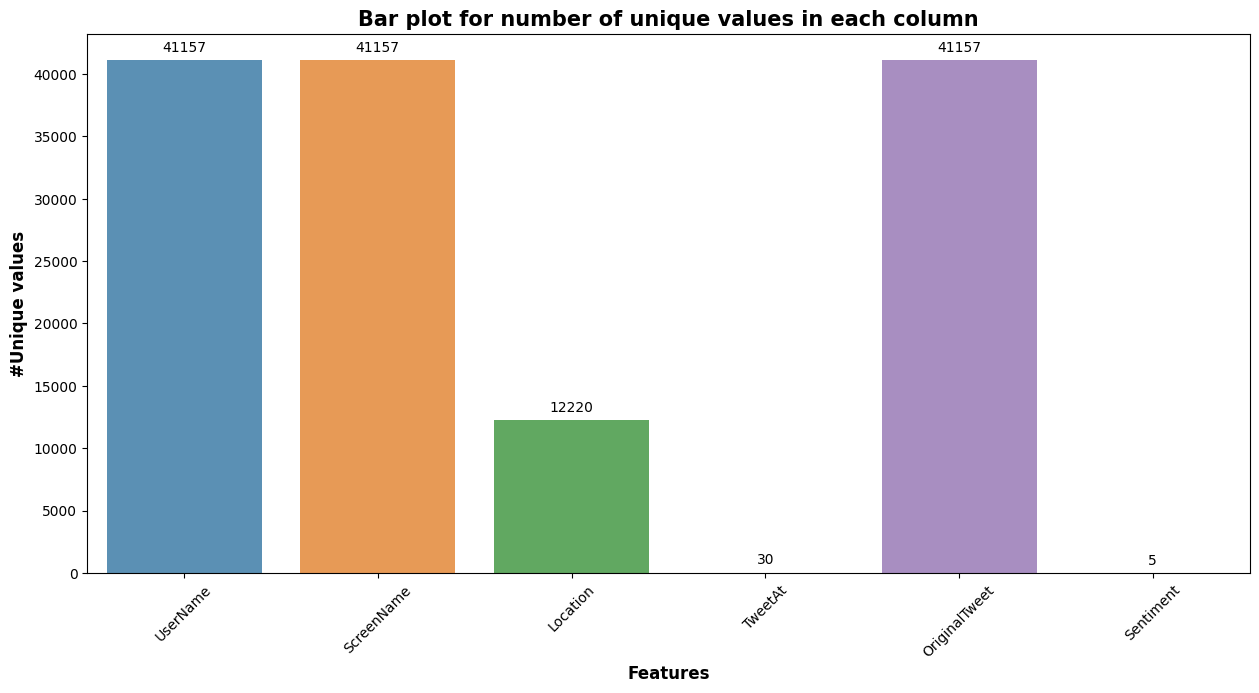

In [ ]:
print(train_df.head(5))
print(" ======================================  ")
print(test_df.head(5))

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

column_df = pd.DataFrame()
column_df['Features'] = train_df.columns
column=[]
for i in train_df.columns:
    column.append(train_df[i].nunique())
column_df['Uniques'] = column

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=column_df['Features'], y=column_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=45)
plt.show()

# Checking the distribution of sentiment data
It shows the number of each setiment is balanced.

0


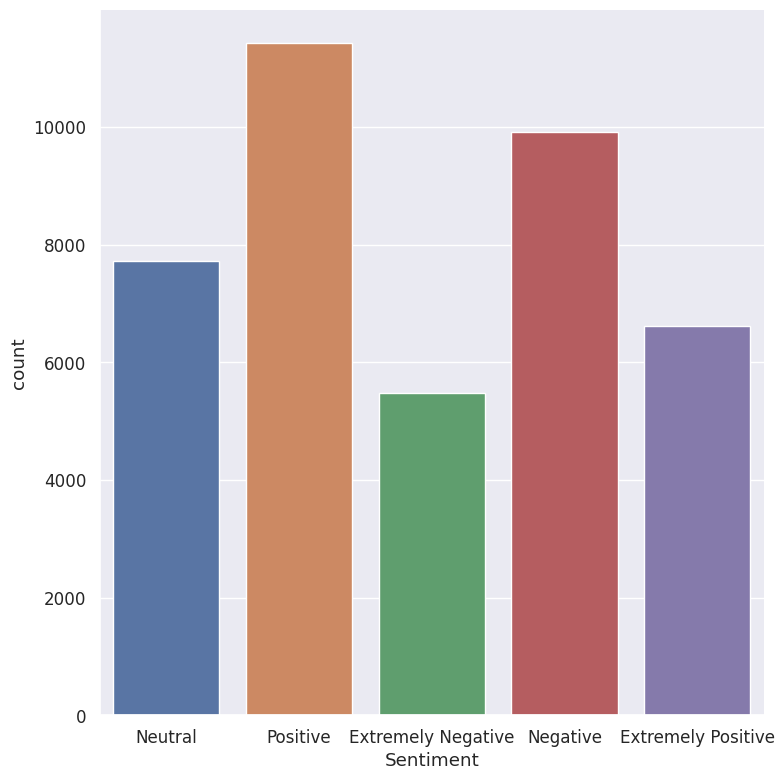

In [ ]:
# Checking missing value
c = 0
for value in train_df["Sentiment"]:
  if value == "" :
    c+=1
print(c)

# checking distribution
sns.set(font_scale=1.1)
sns.catplot(x="Sentiment", data=train_df, kind="count", height=8)

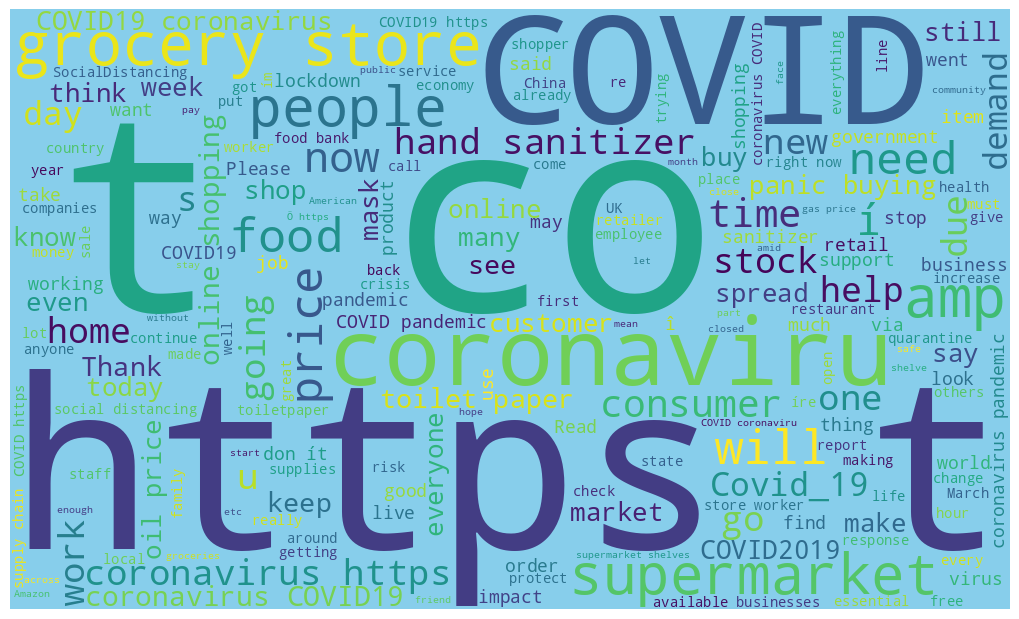

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_words = ' '.join(word for word in train_df["OriginalTweet"])

wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'skyblue',
    min_font_size = 10).generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# **Texts pre-precoessing**

First, we define some functions that will be used for preprocessing the text. Typically, text preprocessing involves removing irregular expressions, Expanding contractions, tokenizing, removing punctuation and stopwords, and stemming. Since the training and test datasets are separate, using functions makes our work easier and more efficient.

The contractions_dict was generated via prompt in ChatGPT. We will be using this dictionary in the expanding_words function.

In [ ]:
contractions_dict = {
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'll": "he shall / he will",
    "he's": "he is",
    "I'd": "I had / I would",
    "I'll": "I shall / I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'll": "it shall / it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she had / she would",
    "she'll": "she shall / she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they had / they would",
    "they'll": "they shall / they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'll": "we shall / we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who had / who would",
    "who'll": "who shall / who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you had / you would",
    "you'll": "you shall / you will",
    "you're": "you are",
    "you've": "you have"
}

# In the context of sentiment analysis or text sentiment classification, words such as "not", "no", "nor", "very", etc. are often considered an important part of the sentiment context and therefore should not be treated as stop words. Remove. These words can often influence the emotional polarity of a text, so their presence and location can be very important when analyzing sentiment.

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_english = stopwords.words('english')
print(stopwords_english)

word_keep = ["not", "no", "nor", "very", "too", "more", "most", "few", "some"]
stop_words = [w for w in stopwords_english if w not in word_keep]
print(len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')

def preprocessing(tweet):
    # cleaning text
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://(?:www\.[^\s\n\r]+|[^\s\n\r]+)', '', tweet)
    # remove hashtag (#)
    tweet = re.sub(r'#\w+', '', tweet)
    #replaces newline (\n) and carriage return (\r) characters in a tweet with an empty string
    tweet = re.sub(r'[\n\r]', '', tweet)
    #replaces the numbers with an empty string
    tweet = re.sub(r'\d+', '', tweet)



    # Expending contraction word
    words = tweet.split()
    expanded_words = []
    for word in words:
        if word.lower() in contractions_dict:
            expanded_words.extend(contractions_dict[word.lower()].split("/"))
        else:
            expanded_words.append(word)
    tweet = " ".join(expanded_words)

    # Tokenize sentence and remove stop words
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    new_tweet = tokenizer.tokenize(tweet)
    # new_tweet = word_tokenize(tweet)
    clean_tweet = []
    for word in new_tweet:
        # if (word not in string.punctuation):
        if (word not in stop_words and word not in string.punctuation):  # remove punctuation and stopwords
            clean_tweet.append(word)

    # clean_string = " ".join(clean_tweet)
    # return clean_string

    lemmatizer = WordNetLemmatizer()

    nouns_lemmatized = [lemmatizer.lemmatize(word) for word in clean_tweet]
    verbs_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in clean_tweet]
    adjs_lemmatized = [lemmatizer.lemmatize(word, pos="a") for word in clean_tweet]
    clean_string = " ".join(adjs_lemmatized)
    return clean_string



    # stemmer = PorterStemmer()

    # # Create an empty list to store the stems
    # stemmed_tweets = []

    # for word in clean_tweet:
    #     stem_word = stemmer.stem(word)  # stemming word
    #     stemmed_tweets.append(stem_word)  # append to the list

    # clean_string = " ".join(stemmed_tweets)
    # return clean_string
    # return stemmed_tweets


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
train_texts = []
test_texts = []

for i in range(len(train_df["OriginalTweet"])):
  train_texts.append(train_df["OriginalTweet"][i])


for j in range(len(test_df["OriginalTweet"])):
  test_texts.append(test_df["OriginalTweet"][j])



In [ ]:
train_cleaned = []

for tweet in train_texts:
  train_cleaned.append(preprocessing(tweet))

test_cleaned = []
for tweet in test_texts:
  test_cleaned.append(preprocessing(tweet))

for i in range(5):
  print(train_texts[i])
  print(train_cleaned[i])
  print("======================================")

print("======  Cleaned test data =========")

for i in range(5):
  print(test_texts[i])
  print(test_cleaned[i])
  print("======================================")


# checking size
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_df["OriginalTweet"]).toarray()

X_cleaned = vectorizer.fit_transform(train_cleaned).toarray()

print(X.shape)
print(X_cleaned.shape)
print(f"token number from {X.shape} to {X_cleaned.shape}")

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds not order
Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak





#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
food stock not one empty ... please not panic enough food everyone not take more need stay

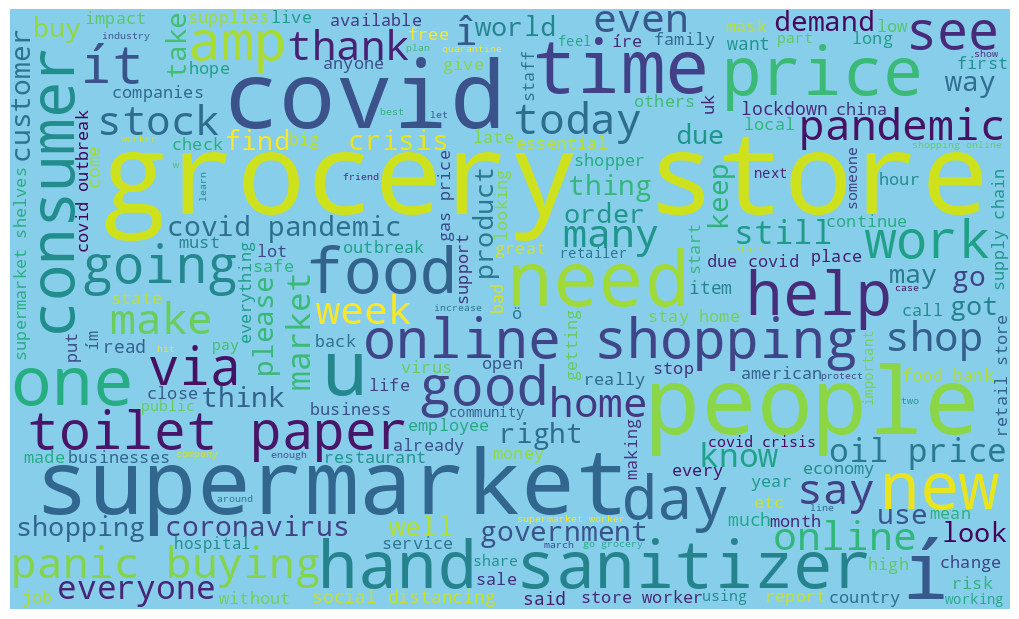

In [ ]:
all_words = ' '.join(word for word in train_cleaned)

wordcloud = WordCloud(
    width = 1000,
    height = 600,
    background_color = 'skyblue',
    min_font_size = 10).generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Labels numerization.and features vectorization

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_df["Sentiment"])
y_test = le.fit_transform(test_df["Sentiment"])
labels = le.classes_
print(labels)
print(y_train.shape)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_cleaned).toarray()
X_test = vectorizer.transform(test_cleaned).toarray()


['Extremely Negative' 'Extremely Positive' 'Negative' 'Neutral' 'Positive']
(41157,)


# Naive Bayes classifier


=================       GaussianNB       ===================


<Figure size 1000x800 with 0 Axes>

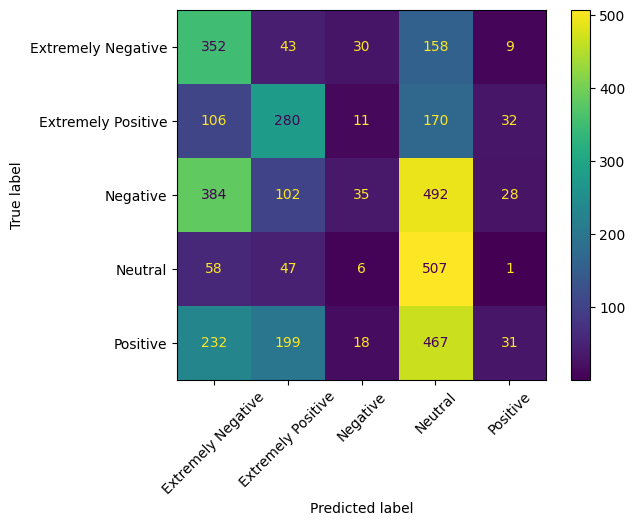


=================       GaussianNB       ===================
training accuracy Score    :  0.409991010034745
Validation accuracy Score :  0.3172722485518694
Precision: 0.333
Recall: 0.317
F1: 0.233
              precision    recall  f1-score   support

           0       0.31      0.59      0.41       592
           1       0.42      0.47      0.44       599
           2       0.35      0.03      0.06      1041
           3       0.28      0.82      0.42       619
           4       0.31      0.03      0.06       947

    accuracy                           0.32      3798
   macro avg       0.33      0.39      0.28      3798
weighted avg       0.33      0.32      0.23      3798


=================       MultinomialNB       ===================


<Figure size 1000x800 with 0 Axes>

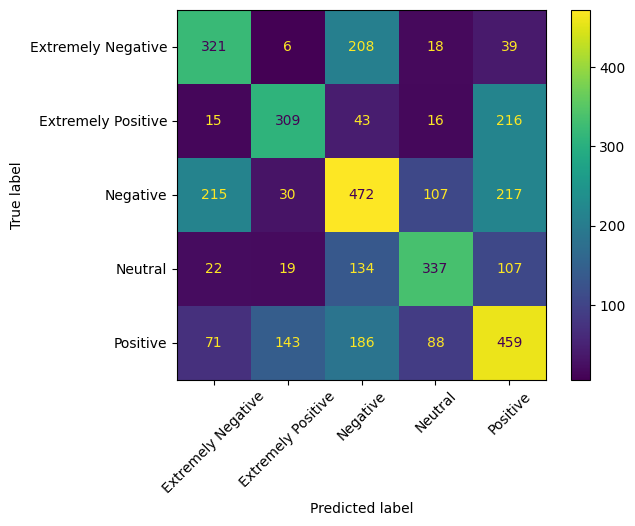


=================       MultinomialNB       ===================
training accuracy Score    :  0.6222513788662924
Validation accuracy Score :  0.49973670352817273
Precision: 0.505
Recall: 0.500
F1: 0.501
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       592
           1       0.61      0.52      0.56       599
           2       0.45      0.45      0.45      1041
           3       0.60      0.54      0.57       619
           4       0.44      0.48      0.46       947

    accuracy                           0.50      3798
   macro avg       0.52      0.51      0.51      3798
weighted avg       0.51      0.50      0.50      3798


=================       ComplementNB       ===================


<Figure size 1000x800 with 0 Axes>

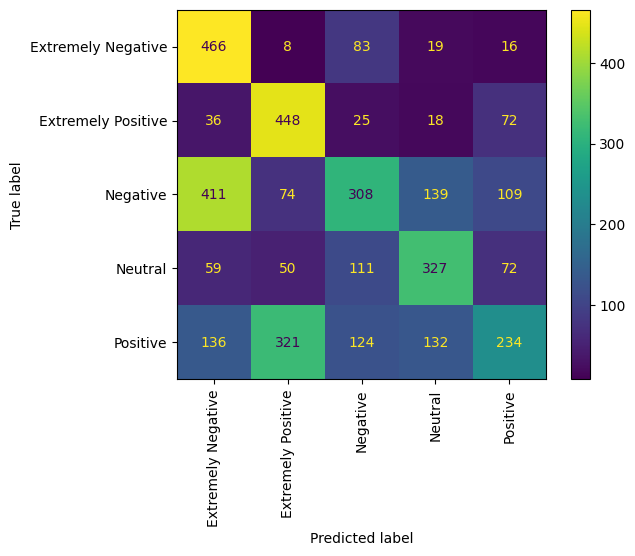


=================       ComplementNB       ===================
training accuracy Score    :  0.5583011395388391
Validation accuracy Score :  0.4694576092680358
Precision: 0.474
Recall: 0.469
F1: 0.445
              precision    recall  f1-score   support

           0       0.42      0.79      0.55       592
           1       0.50      0.75      0.60       599
           2       0.47      0.30      0.36      1041
           3       0.51      0.53      0.52       619
           4       0.47      0.25      0.32       947

    accuracy                           0.47      3798
   macro avg       0.47      0.52      0.47      3798
weighted avg       0.47      0.47      0.44      3798



In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print('\n=================       GaussianNB       ===================')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()
print('\n=================       GaussianNB       ===================')
print("training accuracy Score    : ",gnb.score(X_train,y_train))
print("Validation accuracy Score : ",accuracy_score(y_test,y_pred) )
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)
print('\n=================       MultinomialNB       ===================')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()
print('\n=================       MultinomialNB       ===================')
print("training accuracy Score    : ",mnb.score(X_train,y_train))
print("Validation accuracy Score : ",accuracy_score(y_test,y_pred) )
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

# ComplementNB

cnb = ComplementNB()
cnb.fit(X_train, y_train)
y_pred = cnb.predict(X_test)
print('\n=================       ComplementNB       ===================')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90)
plt.show()

print('\n=================       ComplementNB       ===================')
print("training accuracy Score    : ",cnb.score(X_train,y_train))
print("Validation accuracy Score : ",accuracy_score(y_test,y_pred) )
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print(classification_report(y_test, y_pred))


# **Neural Network with text pre-processing**
1.sklearn MLP classifier

2.tensorflow sequential

In [ ]:
# NN model training history plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



=================       MLP classifier       ===================


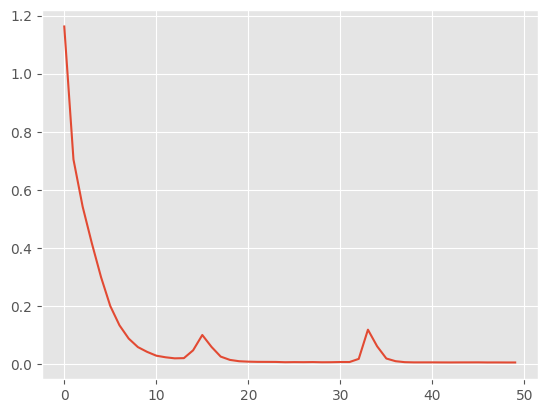

<Figure size 1000x800 with 0 Axes>

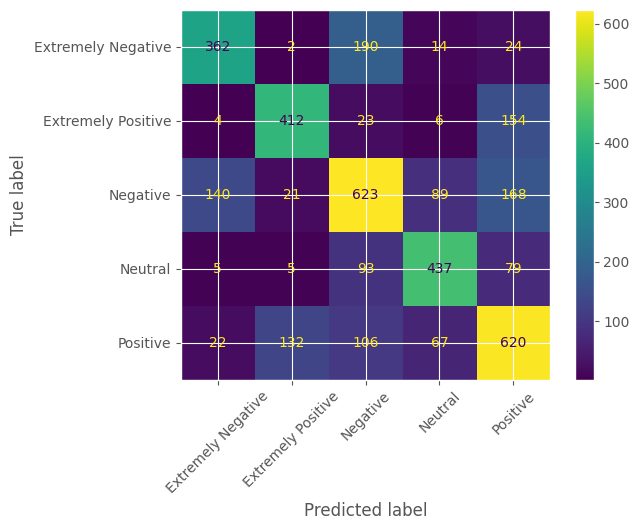

Precision: 0.649
Recall: 0.646
F1: 0.647
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       592
           1       0.72      0.69      0.70       599
           2       0.60      0.60      0.60      1041
           3       0.71      0.71      0.71       619
           4       0.59      0.65      0.62       947

    accuracy                           0.65      3798
   macro avg       0.66      0.65      0.66      3798
weighted avg       0.65      0.65      0.65      3798



In [ ]:
# MLP classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
mlp = MLPClassifier(hidden_layer_sizes=(100,50,10), max_iter=50, random_state=42)
mlp.fit(X_train,y_train)
plt.plot(mlp.loss_curve_)


y_pred = mlp.predict(X_test)
print('\n=================       MLP classifier       ===================')
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print(classification_report(y_test, y_pred))


In [ ]:
#Transform to OneHotEncoder from Scikit-learn
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
train_labels = y_train.reshape((-1, 1)) # change to a column vector from a row vector.
Y_train=encoder.fit_transform(train_labels) #transform to a nxm matrix where n = number of datapoints and m is the number of labels.
test_labels = y_test.reshape((-1, 1))
Y_test=encoder.fit_transform(test_labels)

print(y_train)
print(Y_train)

[3 4 4 ... 4 3 2]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# 2. sequential neural network model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=5000, activation='relu',name='input'))
model.add(Dense(50, activation='relu',name='hidden1'))
model.add(Dense(10, activation='relu',name='hidden2'))
model.add(Dense(5, activation='softmax',name='output'))
print(model.summary())
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=30, verbose=False,batch_size=32,validation_data=(X_test, Y_test), shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 100)               500100    
                                                                 
 hidden1 (Dense)             (None, 50)                5050      
                                                                 
 hidden2 (Dense)             (None, 10)                510       
                                                                 
 output (Dense)              (None, 5)                 55        
                                                                 
Total params: 505715 (1.93 MB)
Trainable params: 505715 (1.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
plot_history(history)
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("accuracy:", accuracy)

# Plot NN model confusion matrix
import numpy as np
y_pred_m = model.predict(X_test)
y_pred = []
for m in y_pred_m:
  max_index = np.argmax(m)
  y_pred.append(max_index)

for i in range(10):
    print(y_test[i], " V.S. ", y_pred[i])


confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()

# batch size 64

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=5000, activation='relu',name='input'))
model.add(Dense(50, activation='relu',name='hidden1'))
model.add(Dense(10, activation='relu',name='hidden2'))
model.add(Dense(5, activation='softmax',name='output'))
print(model.summary())
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs=30, verbose=False,batch_size=64,validation_data=(X_test, Y_test), shuffle=False)
plot_history(history)
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("accuracy:", accuracy)

# Plot NN model confusion matrix
import numpy as np
y_pred_m = model.predict(X_test)
y_pred = []
for m in y_pred_m:
  max_index = np.argmax(m)
  y_pred.append(max_index)

for i in range(10):
    print(y_test[i], " V.S. ", y_pred[i])


confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()

In [ ]:
plot_history(history)
# evaluate the model
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("accuracy:", accuracy)

# Plot NN model confusion matrix
import numpy as np
y_pred_m = model.predict(X_test)
y_pred = []
for m in y_pred_m:
  max_index = np.argmax(m)
  y_pred.append(max_index)

for i in range(10):
    print(y_test[i], " V.S. ", y_pred[i])


confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()

## CNN

Epoch 1/50
644/644 [==============================] - 61s 93ms/step - loss: 1.5526 - accuracy: 0.2964 - val_loss: 1.5054 - val_accuracy: 0.3207
Epoch 2/50
644/644 [==============================] - 58s 90ms/step - loss: 1.3481 - accuracy: 0.4221 - val_loss: 1.1755 - val_accuracy: 0.5192
Epoch 3/50
644/644 [==============================] - 58s 90ms/step - loss: 1.0456 - accuracy: 0.5753 - val_loss: 0.9672 - val_accuracy: 0.6403
Epoch 4/50
644/644 [==============================] - 63s 97ms/step - loss: 0.8945 - accuracy: 0.6570 - val_loss: 0.8750 - val_accuracy: 0.6819
Epoch 5/50
644/644 [==============================] - 58s 91ms/step - loss: 0.8146 - accuracy: 0.6992 - val_loss: 0.8358 - val_accuracy: 0.7004
Epoch 6/50
644/644 [==============================] - 59s 92ms/step - loss: 0.7641 - accuracy: 0.7208 - val_loss: 0.8150 - val_accuracy: 0.7001
Epoch 7/50
644/644 [==============================] - 59s 91ms/step - loss: 0.7284 - accuracy: 0.7418 - val_loss: 0.8056 - val_accuracy:

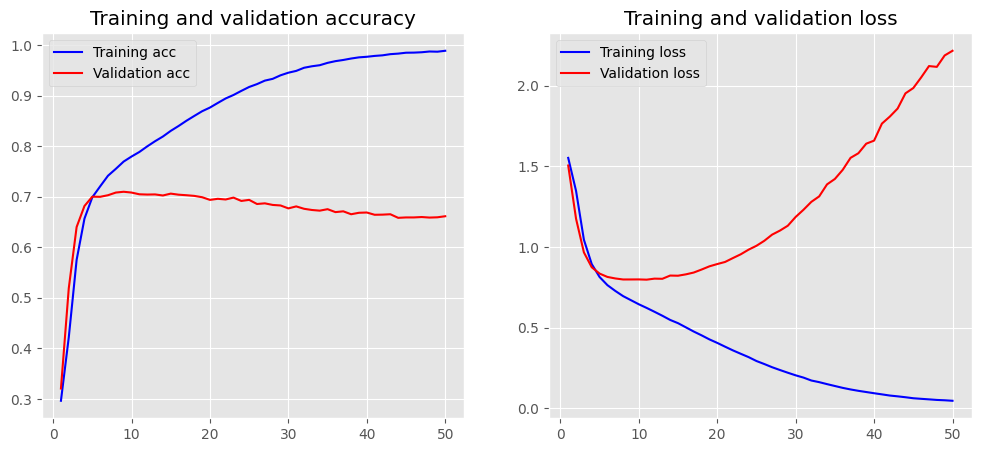

In [ ]:
"""               CNN                 """
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

max_words = 5000
maxlen=100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_cleaned)
X_train = tokenizer.texts_to_sequences(train_cleaned)
X_test = tokenizer.texts_to_sequences(test_cleaned)
X_train_pad = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test, padding='post', maxlen=maxlen)
# 构建CNN模型
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=X_train_pad.shape[1]))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, validation_data=(X_test_pad, y_test))
plot_history(history)



119/119 [==============================] - 4s 27ms/step
0
0  V.S.  2
4  V.S.  4
1  V.S.  1
2  V.S.  2
3  V.S.  3
3  V.S.  3
4  V.S.  4
3  V.S.  2
0  V.S.  0
1  V.S.  4


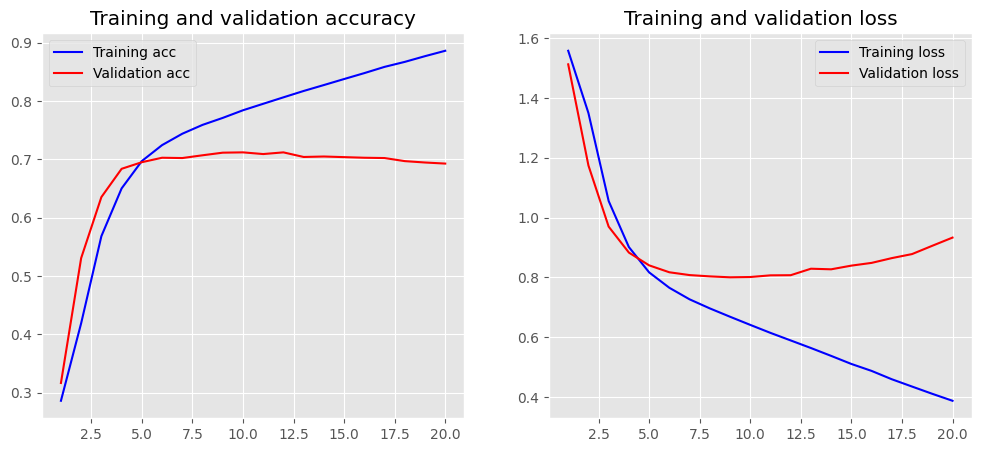

<Figure size 1000x800 with 0 Axes>

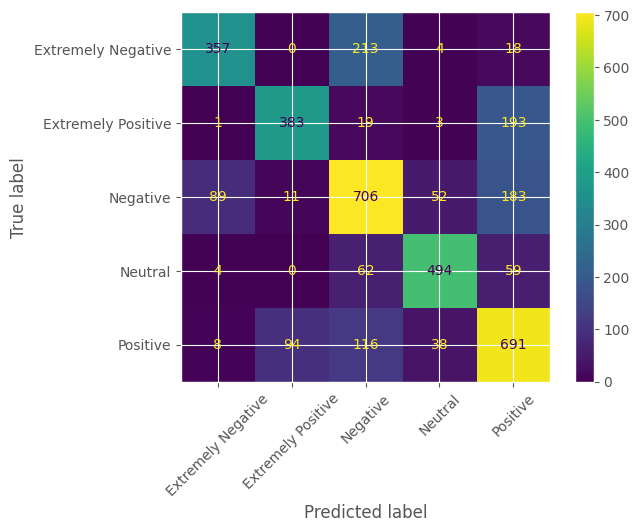

Precision: 0.705
Recall: 0.693
F1: 0.694
              precision    recall  f1-score   support

           0       0.78      0.60      0.68       592
           1       0.78      0.64      0.70       599
           2       0.63      0.68      0.65      1041
           3       0.84      0.80      0.82       619
           4       0.60      0.73      0.66       947

    accuracy                           0.69      3798
   macro avg       0.73      0.69      0.70      3798
weighted avg       0.71      0.69      0.69      3798



In [ ]:
plot_history(history)

import numpy as np
y_pred_pad = model.predict(X_test_pad)

print(y_test[0])
y_pred = []
for m in y_pred_pad:
  max_index = np.argmax(m)
  y_pred.append(max_index)

for i in range(10):
    print(y_test[i], " V.S. ", y_pred[i])

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
disp =  ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45)
plt.show()
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average="weighted"))
print(classification_report(y_test, y_pred))

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           82048     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                      